In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
np.set_printoptions(suppress=True)

In [12]:
user_data = pd.read_excel(open(r'C:\Users\Louie\Repositories\Springboard\Small Projects\relax_challenge\takehome_users.xlsx', 'rb')
                      ,sheet_name='takehome_users')
user_data.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:00,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:00,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:00,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:00,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:00,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


## Clean
Get label data through login sessions and using the criteria defined in the PDF. Merge with features, then strip dataframe of irrelevant columns.

In [3]:
engagment = pd.read_csv('takehome_user_engagement.csv')
engagment.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
engagment[['time_stamp']] = engagment[['time_stamp']].apply(pd.to_datetime)
engagment['year'] = engagment.time_stamp.dt.year
engagment['month'] = engagment.time_stamp.dt.month
engagment['day'] = engagment.time_stamp.dt.day
engagment.head()

,time_stamp,user_id,visited,year,month,day
0,2014-04-22 03:53:30,1,1,2014,4,22
1,2013-11-15 03:45:04,2,1,2013,11,15
2,2013-11-29 03:45:04,2,1,2013,11,29
3,2013-12-09 03:45:04,2,1,2013,12,9
4,2013-12-25 03:45:04,2,1,2013,12,25


In [5]:
logins = engagment.groupby(['user_id','year','month','day'])['time_stamp'].max().reset_index()
logins['int_time'] = pd.to_numeric(logins.time_stamp)
logins.head()

,user_id,year,month,day,time_stamp,int_time
0,1,2014,4,22,2014-04-22 03:53:30,1398138810000000000
1,2,2013,11,15,2013-11-15 03:45:04,1384487104000000000
2,2,2013,11,29,2013-11-29 03:45:04,1385696704000000000
3,2,2013,12,9,2013-12-09 03:45:04,1386560704000000000
4,2,2013,12,25,2013-12-25 03:45:04,1387943104000000000


In [6]:
def timerange(x):
    return pd.to_timedelta(x.iloc[2] - x.iloc[0]).days

In [7]:
def adopted(user):
    return (user.rolling(3).agg({'diff':timerange}).min() <= 7).iloc[0]

In [8]:
users = []
labels = []

for id_, group in logins.groupby(['user_id']):
    users.append(id_)
    labels.append(adopted(group['int_time']))

In [9]:
user_labels = pd.DataFrame(list(zip(users,labels)),columns=['user_id','adopted'])
user_labels.head()

,user_id,adopted
0,1,False
1,2,True
2,3,False
3,4,False
4,5,False


## Investigate
Analyze P(Y|X) using a multinomial distribution to represent our dataset. Examine correlations between the variables.

In [50]:
df = user_data.merge(user_labels, left_on='object_id', right_on='user_id', how='left')

df['object_id'] = df['object_id'].astype(int)
df['adopted'] = df['adopted'].fillna(False).astype(int)

df.index = df['object_id']
df = df[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'adopted']]
df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted
object_id,,,,
1,GUEST_INVITE,1,0,0
2,ORG_INVITE,0,0,1
3,ORG_INVITE,0,0,0
4,GUEST_INVITE,0,0,0
5,GUEST_INVITE,0,0,0


In [34]:
df.adopted.mean()

0.138

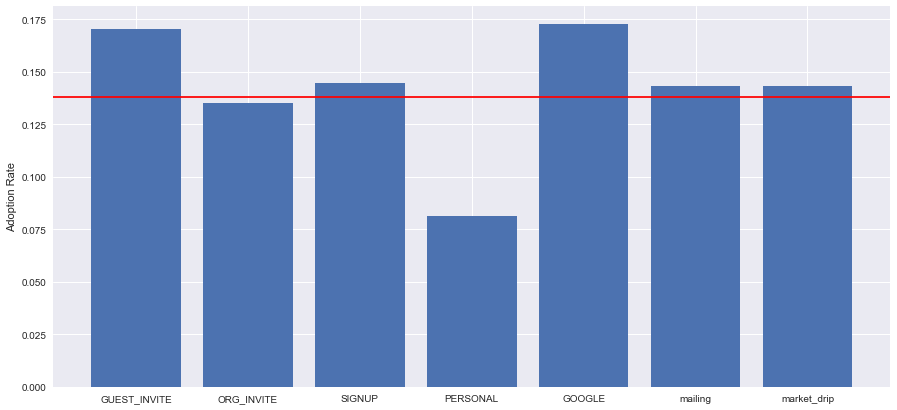

In [54]:
GUEST_INVITE = df[df['creation_source'] == 'GUEST_INVITE']['adopted'].mean()
ORG_INVITE = df[df['creation_source'] == 'ORG_INVITE']['adopted'].mean()
SIGNUP = df[df['creation_source'] == 'SIGNUP']['adopted'].mean()
PERSONAL_PROJECTS = df[df['creation_source'] == 'PERSONAL_PROJECTS']['adopted'].mean()
SIGNUP_GOOGLE_AUTH = df[df['creation_source'] == 'SIGNUP_GOOGLE_AUTH']['adopted'].mean()

mailing = df[df['opted_in_to_mailing_list'] == 1]['adopted'].mean()
market_drip = df[df['enabled_for_marketing_drip'] == 1]['adopted'].mean()

total_mean = df.adopted.mean()

plt.bar(np.arange(7), [GUEST_INVITE, ORG_INVITE, SIGNUP, PERSONAL_PROJECTS, SIGNUP_GOOGLE_AUTH, mailing, market_drip])
plt.xticks(np.arange(7), ['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL', 'GOOGLE', 'mailing', 'market_drip'])
plt.ylabel('Adoption Rate')

plt.axhline(y=total_mean, color='red')

fig = plt.gcf()
_ = fig.set_size_inches(15, 7)

In [95]:
import scipy.stats as st

var = total_mean * (1 - total_mean)

guest_diff = GUEST_INVITE - total_mean
ord_diff = ORG_INVITE - total_mean
sign_diff = SIGNUP - total_mean
pers_diff = PERSONAL_PROJECTS - total_mean
goog_diff = SIGNUP_GOOGLE_AUTH - total_mean

mail_diff = mailing - total_mean
mark_diff = market_drip - total_mean

print('Guest p-value: {0}'.format(st.norm.cdf((guest_diff * np.sqrt(len(df[df['creation_source'] == 'GUEST_INVITE']))) / var)))
print('Organization p-value: {0}'.format(st.norm.cdf((ord_diff * np.sqrt(len(df[df['creation_source'] == 'ORG_INVITE']))) / var)))
print('Signup p-value: {0}'.format(st.norm.cdf((sign_diff * np.sqrt(len(df[df['creation_source'] == 'SIGNUP']))) / var)))
print('Personal Project p-value: {0}'.format(st.norm.cdf((pers_diff * np.sqrt(len(df[df['creation_source'] == 'PERSONAL_PROJECTS']))) / var)))
print('Google Auth p-value: {0}'.format(st.norm.cdf((goog_diff * np.sqrt(len(df[df['creation_source'] == 'SIGNUP_GOOGLE_AUTH']))) / var)))

print('Mail p-value: {0}'.format(st.norm.cdf((mail_diff * np.sqrt(total)) / var)))
print('Market Drip p-value: {0}'.format(st.norm.cdf((mark_diff * np.sqrt(total)) / var)))

Guest p-value: 1.0
Organization p-value: 0.0462596481142828
Signup p-value: 0.9949894612086956
Personal Project p-value: 5.87866566079021e-106
Google Auth p-value: 1.0
Mail p-value: 0.999999437225958
Market Drip p-value: 0.9999996929729139


In [71]:
total = len(df)

p_guest = len(df[df['creation_source'] == 'GUEST_INVITE']) / total
p_org = len(df[df['creation_source'] == 'ORG_INVITE']) / total
p_sign = len(df[df['creation_source'] == 'SIGNUP']) / total
p_pers = len(df[df['creation_source'] == 'PERSONAL_PROJECTS']) / total
p_goog = len(df[df['creation_source'] == 'SIGNUP_GOOGLE_AUTH']) / total

p_mail = len(df[df['opted_in_to_mailing_list'] == 1]) / total
p_mark = len(df[df['enabled_for_marketing_drip'] == 1]) / total

p_guest_mail = len(df[(df['creation_source'] == 'GUEST_INVITE') & (df['opted_in_to_mailing_list'] == 1)]) / total
p_org_mail = len(df[(df['creation_source'] == 'ORG_INVITE') & (df['opted_in_to_mailing_list'] == 1)]) / total
p_sign_mail = len(df[(df['creation_source'] == 'SIGNUP') & (df['opted_in_to_mailing_list'] == 1)]) / total
p_pers_mail = len(df[(df['creation_source'] == 'PERSONAL_PROJECTS') & (df['opted_in_to_mailing_list'] == 1)]) / total
p_goog_mail = len(df[(df['creation_source'] == 'SIGNUP_GOOGLE_AUTH') & (df['opted_in_to_mailing_list'] == 1)]) / total

p_guest_market = len(df[(df['creation_source'] == 'GUEST_INVITE') & (df['enabled_for_marketing_drip'] == 1)]) / total
p_org_market = len(df[(df['creation_source'] == 'ORG_INVITE') & (df['enabled_for_marketing_drip'] == 1)]) / total
p_sign_market = len(df[(df['creation_source'] == 'SIGNUP') & (df['enabled_for_marketing_drip'] == 1)]) / total
p_pers_market = len(df[(df['creation_source'] == 'PERSONAL_PROJECTS') & (df['enabled_for_marketing_drip'] == 1)]) / total
p_goog_market = len(df[(df['creation_source'] == 'SIGNUP_GOOGLE_AUTH') & (df['enabled_for_marketing_drip'] == 1)]) / total

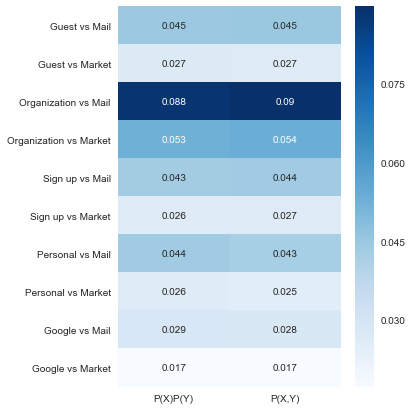

In [82]:
probs = [[p_guest * p_mail, p_guest_mail],
 [p_guest * p_mark, p_guest_market],
 [p_org * p_mail, p_org_mail],
 [p_org * p_mark, p_org_market],
 [p_sign * p_mail, p_sign_mail],
 [p_sign * p_mark, p_sign_market],
 [p_pers * p_mail, p_pers_mail],
 [p_pers * p_mark, p_pers_market],
 [p_goog * p_mail, p_goog_mail],
 [p_goog * p_mark, p_goog_market]]

sns.heatmap(probs, cmap='Blues', annot=True, xticklabels=['P(X)P(Y)','P(X,Y)'],
           yticklabels=['Guest vs Mail', 'Guest vs Market',
                       'Organization vs Mail', 'Organization vs Market',
                       'Sign up vs Mail', 'Sign up vs Market',
                       'Personal vs Mail', 'Personal vs Market',
                       'Google vs Mail', 'Google vs Market'])

fig = plt.gcf()
_ = fig.set_size_inches(5, 7)